# Summer vibes: 
## Am I right to be upset by this summer weather?

## Summary: 
As summer ends up in Tours, France, I feel upset and frustrated. I have the feeling that this summer was not a genuine summer. However, I read that the statistics are not bad compared to the mean values. Should I trust the news? Well, no. Let us make us of my data science skills and check those assertions!


Besides, I have lived in different cities in the last years and I want to compare the weather statistics in those cities, namely Berlin(Ge), Groningen(Nl) and Tours(Fr). Hence, I will check my feelings that the weather is much poorer in some cities (Sorry Dutch people but you know I am right...).  

## Scheme:
### Importation and cleaning
- Import csv files and format the dataframe
- Get monthly and yearly summer statistics

### Comparison of the three city summer data
- Number of warm days
- Amount of precipitation
- Conclusion: where should have I spent my last 5 summers?

### Tours summer weather analysis
- Comparison of 2021 data with the statistics over the last years 
   - Graphical exploratory analysis
   - Cumulative Distribution Function
- Distribution over summer months
    
### Correlation
- Potential correlations between daily features.
    - conclusion: can we apply Machine Learning? 
- "Noël au balcon, Pâques aux tisons ?"   
    - Correlation analysis of Christmas and Easter temperatures.
    - Null hypothesis.

### Machine Learning     
- Classification of months in seasons
- Unsupervised clustering of months


In [46]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from dateutil.easter import *

## Importation and cleaning
### Import data
We are interested in historical daily meteorological data of some european cities. 
We are getting them from the European Climate Assessment & Dataset project, ECAD
(https://www.ecad.eu/). The different parameters are given in independent files that will need to be merged. We stored the files in a directory 'sources'. 
We make a list of the parameters of interest, namely max, min and mean temperatures, precipitation amount and sunshine hours.  

In [47]:
#list of files of interest
plist=['TX','TN','TG','RR','HU','SS','QQ','PP']
#Source: ecad
path='sources/'

Let us have a look at the files.
The first 18 lines are description so we need to skip them.
The header contains spaces that we should discard.
There are 4 columns:
'SOUID,    DATE,   TX, Q_TX'.
SOUID gives information on the source, date is self-explanatory, Tx, here is the parameter and Q_ is a quality code of the previous value. Only the date and the parameter value will be useful in our study.


In [48]:
#Import every file corresponding to the parameters listed in li, 
#convert them in dataframes and compile them in a list.
lidf=[pd.read_csv(path+f+'_STAID002190.csv',skipinitialspace=True, skiprows=18) for f in plist]
#Merge all the parameter dataframe into one global dataframe on the date column.
dftest=lidf[0].drop(['SOUID'],1)
for i in lidf[1:]:
    dftest=dftest.merge(i.drop(['SOUID'],1), on=['DATE'])
#Drop quality columns.    
dftest.drop(dftest.columns[dftest.columns.str.startswith('Q_')],1,inplace=True)    
display(dftest.head())

DATE   TX  TN  TG   RR  HU  SS  QQ    PP
0  19610101   75 -14  30   82  92  46  54 -9999
1  19610102  109  22  66  364  95   0  16 -9999
2  19610103   72  35  54   41  88  12  33 -9999
3  19610104   82  22  52   18  90  42  53 -9999
4  19610105   72  -3  34   94  87  50  57 -9999

Let us first define each parameter whose name are not self-explanatory.
- TX is the daily maximum temperature,
- TN is the daily minimun temperature,
- TG is the daily mean temperature,
- RR is the daily precipitation amount, 
- HU is the daily humidity,
- SS is the daily sunshine hours,
- QQ is the daily global radiation in W/m²,
- PP is the daily sea level pressure. 

The documentation of the data states that the temperatures are given in 0.1°C, the precipitation amount in 0.1mm and the sunshine hours in 0.1hour. Besides, missing values are filled by -9999.
Let's check by displaying information of the dataframe.

In [49]:
display(dftest.describe())

DATE           TX            TN            TG            RR  \
count  2.215800e+04  22158.00000  22158.000000  22158.000000  22158.000000   
mean   1.990902e+07    -23.37192   -108.047567    -65.713151   -162.669555   
std    1.751340e+05   1351.28567   1338.884985   1344.935534   1336.050769   
min    1.961010e+07  -9999.00000  -9999.000000  -9999.000000  -9999.000000   
25%    1.976030e+07    101.00000     29.000000     67.000000      0.000000   
50%    1.991050e+07    154.00000     74.000000    114.000000      0.000000   
75%    2.006070e+07    216.00000    115.000000    164.000000     16.000000   
max    2.021083e+07    408.00000    226.000000    312.000000    620.000000   

                 HU            SS            QQ            PP  
count  22158.000000  22158.000000  22158.000000  22158.000000  
mean    -102.991470  -2711.228044    142.418901   7481.796146  
std     1338.461888   4485.886058    341.152417   6853.945854  
min    -9999.000000  -9999.000000  -9999.000000  -9999.000000  
25%       70.000000  -9999.000000     56.000000  10077.000000  
50%       80.000000     15.000000    127.000000  10158.000000  
75%       88.000000     67.000000    221.000000  10214.000000  
max      100.000000    160.000000   1424.000000  10450.000000

The max value of TX confirms the assertion that temperatures are given in 0.1°C. We also notice the -9999 min value. 
Therefore the missing values should be replaced by the conventional NaN and the parameter values divided by 10. 
Moreover the date column is of integer type and we would rather convert it in datetime format.

In [50]:
dftest.replace(-9999,np.nan, inplace=True)
plist10=['TX', 'TN', 'TG', 'RR', 'SS', 'PP']
dftest[plist10]=dftest[plist10]/10
dftest['DATE']=pd.to_datetime(dftest['DATE'], format='%Y%m%d')
display(dftest.head())

DATE    TX   TN   TG    RR    HU   SS    QQ  PP
0 1961-01-01   7.5 -1.4  3.0   8.2  92.0  4.6  54.0 NaN
1 1961-01-02  10.9  2.2  6.6  36.4  95.0  0.0  16.0 NaN
2 1961-01-03   7.2  3.5  5.4   4.1  88.0  1.2  33.0 NaN
3 1961-01-04   8.2  2.2  5.2   1.8  90.0  4.2  53.0 NaN
4 1961-01-05   7.2 -0.3  3.4   9.4  87.0  5.0  57.0 NaN

Now, we write a function to import and clean data from any source.

In [51]:
def importdata(source):
    lidf=[pd.read_csv(path+f+source,skipinitialspace=True, skiprows=18) for f in plist]
    df=lidf[0].drop(['SOUID'],1)
    for i in lidf[1:]:
        df=df.merge(i.drop(['SOUID'],1), on=['DATE'])
    df.drop(df.columns[df.columns.str.startswith('Q_')],1,inplace=True)
    df['HU'].replace([0,1],np.NaN, inplace=True)
    df['HU']=df['HU']*10
    df['DATE']=pd.to_datetime(df['DATE'], format='%Y%m%d')
    df.replace(-9999,np.nan, inplace=True)
    df[plist]=df[plist]/10 
    return df

Let us apply our function to import Tours(Fr), Groningen(Nl) and Berlin(Ge) weather history.

In [52]:
tours=importdata('_STAID002190.csv')
groningen=importdata('_STAID000163.csv')
berlin=importdata('_STAID004570.csv')

### Monthly statistics
Since global warming and climate change are a thing, it would not make sense to compare last summmer with statistics over more than a century so one would be willing to restrict the study of the abnormality of summer 2021 to the recent years.
Also, we are interested by monthly statistics so we resample the dataframe on monthly basis. For this purpose, we need to choose the aggregation methods to use for each parameter. We also count days where temperature reaches 25°C. 
Finally, as the scope of our study is mainly the summer weather, we will isolate summer months from the other by adding a boolean type column 'summer'. Here we consider only July and August as the summer months.  

In [53]:
#General function to get monthly statistics of a given city over a given period of time.
def monthstat(city, start):#City dataframe is assumed loaded.
    #select data after a given year 'start', set 'DATE' column as index
    #and resample it to get monthly values. Aggregation functions are given.
    #We also count days where temperature reaches 25°C.
    dfmonthly=city[city['DATE'].dt.year>=start].set_index('DATE').resample('M')\
    .agg({'TX':['mean',lambda ts: (ts > 25).sum()],'TN':'mean','TG':'mean',\
          'RR':'sum','HU':'mean','SS':'sum','QQ':'sum','PP':'mean'})
    #Flatten column index and rename explictly.
    dfmonthly.columns=['TX_mean','Warm days','TN_mean','TG_mean','RR_sum','HU_mean','SS_sum',\
                      'QQ_sum','PP_mean']
    #Identify summer months
    dfmonthly['summer']=dfmonthly.index.month.isin([7,8])
    return dfmonthly

Let's have a look at the Groningen monthly dataframe.

In [54]:
gronmont=monthstat(groningen,2000)
print('Groningen monthly')
display(gronmont.head())

Groningen monthly


TX_mean  Warm days   TN_mean    TG_mean  RR_sum    HU_mean  \
DATE                                                                       
2000-01-31   6.051613        0.0  1.412903   4.032258    56.7  90.709677   
2000-02-29   8.368966        0.0  2.293103   5.313793    81.3  87.068966   
2000-03-31   9.190323        0.0  3.025806   6.232258   100.0  87.322581   
2000-04-30  14.483333        1.0  4.250000   9.460000    45.9  79.400000   
2000-05-31  19.106452        4.0  8.096774  13.745161    83.7  77.354839   

            SS_sum  QQ_sum      PP_mean  summer  
DATE                                             
2000-01-31    53.4    74.6  1021.106452   False  
2000-02-29    96.2   156.9  1015.648276   False  
2000-03-31    64.8   213.3  1017.706452   False  
2000-04-30   146.2   435.2  1008.140000   False  
2000-05-31   221.2   627.3  1014.974194   False

### Yearly summer statistics
To facilitate our study, we might be willing to merge both summer months to compare years.
In this aim, let's resample summer months (July and August) on year. We take the mean daily max, average, and min temperature and the cumulative of daily precipitation and sunshine hours.

To compare the statistics of a specific summer with the average values, we define two new columns 'Temperature' and 'Rain'. 'Temperature' compares the number of warm days (temperature>25°C) of the summer with the average number, 'Cold' and 'Hot' meaning a summer with respectively less, more warm days than usual.
As for 'Rain', it accounts for the quantity of precipitation during the considered summer with respect to the average summer value, 'Wet' for a rainier summer and 'Dry' for a less rainy summer. 

A general function taking as inputs the dataframe of the city as imported with the *importdata* function and the year from which we start the study. 

In [55]:
#General function to get summer statistics of a given city over a given period of time.
def summerstat(city, start):
    dfmonthly=monthstat(city,start)
    dfsum=dfmonthly[dfmonthly.summer==True].resample('Y')\
    .agg({'TX_mean':'mean','Warm days':'sum','TN_mean':'mean',\
          'TG_mean':'mean', 'RR_sum':'sum','SS_sum':'sum'})
    dfsum['Temperature']=(dfsum['Warm days']<dfsum['Warm days'].mean()).map({True:'Cold',False:'Hot'})
    dfsum['Rain']=(dfsum['RR_sum']>dfsum['RR_sum'].mean()).map({True:'Wet',False:'Dry'})
    return dfsum

gronmont=monthstat(groningen,2000)
toursmonthly=monthstat(tours,2000)
gronsum=summerstat(groningen,2000)
berlinsum=summerstat(berlin,2000)
tourssum=summerstat(tours,2000)
display('Groningen summer statistics')
display(gronsum.head())


'Groningen summer statistics'

TX_mean  Warm days    TN_mean    TG_mean  RR_sum  SS_sum  \
DATE                                                                     
2000-12-31  20.595161        3.0  10.956452  15.750000   145.5   282.3   
2001-12-31  23.074194       17.0  12.403226  17.843548   200.2   404.8   
2002-12-31  22.991935       15.0  13.388710  18.112903   224.2   332.7   
2003-12-31  24.554839       23.0  12.570968  18.609677    95.0   468.7   
2004-12-31  22.335484       16.0  12.195161  17.161290   310.2   410.4   

           Temperature Rain  
DATE                         
2000-12-31        Cold  Dry  
2001-12-31         Hot  Wet  
2002-12-31         Hot  Wet  
2003-12-31         Hot  Dry  
2004-12-31         Hot  Wet

## Comparison of the three cities summer data

As we wish to compare the summer weather of the three cities, we aim to join the yearly summer statistic of a given parameter of the three cities. 


In [56]:
def multicities(parameter,year,title):
    all=pd.concat([tourssum[[parameter]],berlinsum[[parameter]],gronsum[[parameter]]],\
                  keys=['tours','berlin','gron'],axis=1)
    all.set_index(all.index.year, inplace=True)
    all.columns=['Tours','Berlin','Groningen']
    all[all.index>year].plot(kind='bar',width=0.8)   
    plt.title(title)
    plt.ylabel(parameter)

We compare the quantity of precipitation and the number of warm days. It would have been interesting to compare the sunshine hours, however this data was not available for Tours for the considered years.

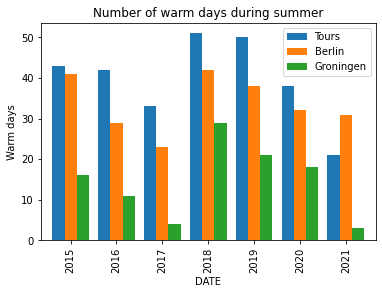

In [57]:
multicities('RR_sum',2014,'Cumulation of precipitation during summer')
multicities('Warm days',2014,'Number of warm days during summer')

*Conclusion: where should have I spent my last 5 summers?*

Based on the graphs above and my personal likes, I should be able to make a choice on the city that would suit me most.    
First, despite my love for the beautiful city of Groningen, I must say that the small number of warm days is an insurmountable flaw. Then, if we consider that less rain and more warm days, the better, Tours is preferable. However, since the number of warm days is the essential criterion for me, I should have spent 2021 summer in Berlin. 

## Tours summer weather analysis


With the *summerstat* function defined above, we aim to compare the 2021 summer with the last twenty summers. We focus on two weather parameters the number of warm days and the volume of rainfalls.  
They are plotted below and the color accounts for the comparison with respect to the mean value on the twenty year period.  

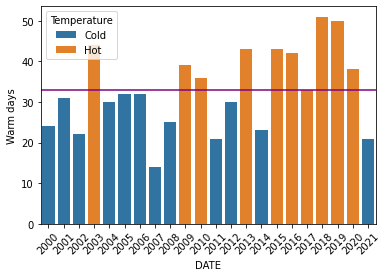

In [58]:
plt.figure(figsize = (6,4))
meanWarm=tourssum['Warm days'].mean()
fig=sns.barplot(x=tourssum.index.year,y='Warm days', hue='Temperature', data=tourssum, dodge=False)
fig.axhline(meanWarm, color='purple')
plt.xticks(rotation=45)
plt.show()

In [59]:
plt.figure(figsize = (6,4))
# print(df)
meanRain=tourssum['RR_sum'].mean()
# medianRain=tourssum['RR_sum'].median()
# tourssum['Rain']=(tourssum['RR_sum']>meanRain).map({True:'Wet',False:'Dry'})
fig=sns.barplot(x=tourssum.index.year,y='RR_sum',hue='Rain',dodge=False,data=tourssum)
fig.axhline(meanRain, color='purple')
plt.xticks(rotation=45)
plt.show()

What can we say on those graphs?  
The number of warm days is significantly smaller than the average value making it a quite cold summer while the sum of the rainfalls is lower than the average, which means that summer 2021 was drier than usual.  
Can we then conclude than summer 2021 was not that bad?   
Well, we need to further study the statistics, namely, to what extend summer 2021 was colder and drier than usual. For this purpose we start by looking at the distribution of the total number of warm days in summer and the amount of the precipitation over the last thirty years. 

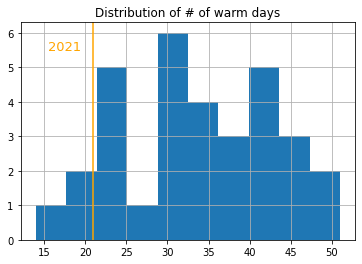

In [60]:
tourssum30=summerstat(tours,1990)
t2021warm=tourssum30.loc['2021-12-31','Warm days']
fig=tourssum30['Warm days'].hist()
fig.axvline(t2021warm, color='orange')
plt.title('Distribution of # of warm days')
plt.annotate('2021',(15.5,5.5), size=13,color='orange')
plt.show()

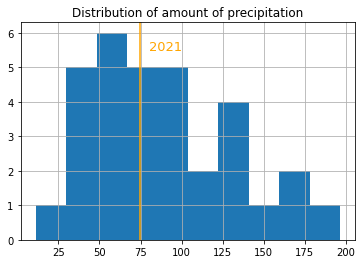

In [61]:
t2021rain=tourssum30.loc['2021-12-31','RR_sum']
fig=tourssum30['RR_sum'].hist()
fig.axvline(t2021rain, color='orange')
plt.title('Distribution of amount of precipitation')
plt.annotate('2021',(80,5.5), size=13,color='orange')
plt.show()

Even if we included more years, our dataset remains limited and the histograms are not easy to interpret and strongly biased by the choice of the number of bins. We can still note that for most of the years, the summer was warmer.
However, to get more quantitative conclusions, we implement the plots of the empirical cumulative distribution functions, ECDF. 

ECDF, what is it?
It takes the measures of a dataset to calculate the probability to get a value smaller or equal to x. Basically it takes all the values of a dataset, order them and for each of them return the number of measurements that gave smaller or equal values. This is what our *ecdf* function does.
On the graphs, the 2021 summer and the corresponding percentile are highlighted with the dashed lines. Finally, to check the nature of the distribution, we also plot the cdf of the normal theoretical function of our data in orange solid line. 


In [62]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)
    # x-data for the ECDF: x
    x = np.sort(data)
    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n
    return x, y

In [63]:
#Preparation of ecdf plot 
def ecdfdata(data,par,year):
    x,y=ecdf(data[par])
    #Get theoretical normal ecdf with empirical mean and std to 
    #check normality of the empirical data.
    samples=np.random.normal(np.mean(data[par]),np.std(data[par]),size=10000)
    x_theor,y_theor=ecdf(samples)
    #Create a dataframe for easy access to ecdf from the x value
    tab=pd.DataFrame(y,index=x,columns=['ECDF'])
    xyear=data.loc[year,par]
    #Extract the ecdf value of the considered year. 
#     print(type(tab.loc[data.loc[year,par],'ECDF']))
    #Handles the case where multiple years has the same value. 
    if type(tab.loc[data.loc[year,par],'ECDF'])==np.float64:
        yyear=(tab.loc[data.loc[year,par],'ECDF'])
    else:
        yyear=max(tab.loc[data.loc[year,par],'ECDF'])
    return x,y,x_theor,y_theor,xyear,yyear  


In [64]:
def ecdfplot(x,y,x_theor,y_theor,xyear,yyear,title):
    fig, ax = plt.subplots()
    plt.plot(x,y, marker='.', linestyle='none')
    plt.plot(x_theor,y_theor, linestyle='-')
    plt.plot(xyear,yyear, marker='+')
    x0,xm=ax.get_xlim()
    y0,ym=ax.get_ylim()
    ax.vlines(xyear, ymin=y0, ymax=yyear, linestyle="dashed")
    ax.hlines(yyear, xmin=x0, xmax=xyear, linestyle='dashed')
    ax.set_xlim(x0,xm)
    ax.set_ylim(y0,ym)
    plt.annotate("({:.0f}, {:.0f}th percentile)".format(xyear,yyear*100),
                 xy=(xyear,yyear),
                 textcoords="offset points", # how to position the text
                 xytext=(10,0), # distance from text to points (x,y)
                 ha='left') # horizontal alignment can be left, right or center)
    plt.title(title)
    plt.show()

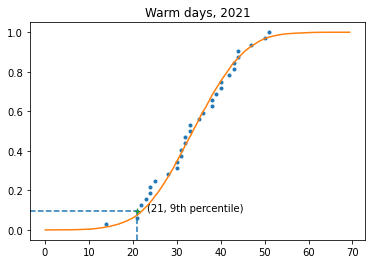

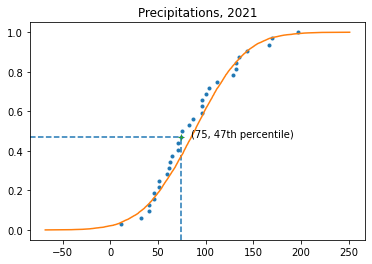

In [65]:
x,y,x_theor,y_theor,xyear,yyear=ecdfdata(tourssum30,'Warm days','2021-12-31')  
ecdfplot(x,y,x_theor,y_theor,xyear,yyear,'Warm days, 2021')
x,y,x_theor,y_theor,xyear,yyear=ecdfdata(tourssum30,'RR_sum','2021-12-31')  
ecdfplot(x,y,x_theor,y_theor,xyear,yyear,'Precipitations, 2021')

Now we can see how summer 2021 ranks in comparison with the last 30 years. 
The number of warm days make 2O21 one of the worst/coldest 9% summers while the rain amount places it in the average, just a bit drier.   
Regarding the nature of the distribution, the ecdf of our data display a good fit with the theoretical cdf, making it consistent with a normal distribution.
As a conclusion, I was quite right to feel that summer 2021 in Tours was not an usual summer. Indeed, although averagely wet there was much less warm days than most of the last 30 years.
 

Finally, for the sake of curiosity, let me disgress a bit on the summer temperatures and rainfalls. At this point, my question is: are the number of warm days and the amount of precipitation evenly distributed in both summer months?

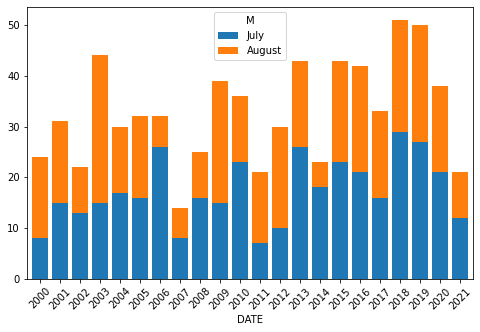

In [66]:
df=toursmonthly[toursmonthly.summer==True]
df=df.assign(M=df.index.month.map({7:'July',8:'August'}))
# sns.set(rc={'figure.figsize':(11.7,8.27)})
dpi=df.pivot(columns='M', values='Warm days').resample('Y').sum()
dpi=dpi[['July','August']]
# print(dpi.head())
dpi.set_index(dpi.index.year).plot(kind='bar', stacked=True, width=0.8,figsize = (8,5))
plt.xticks(rotation=45)
plt.show()

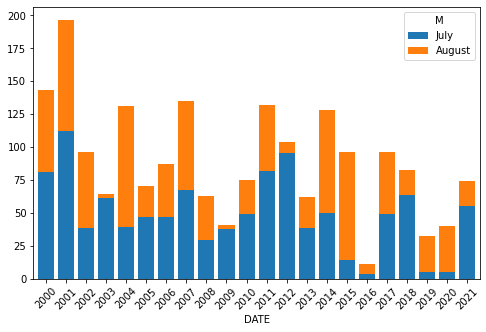

In [67]:
dpi=df.pivot(columns='M', values='RR_sum').resample('Y').sum()
dpi=dpi[['July','August']]
# print(dpi.head())
dpi.set_index(dpi.index.year).plot(kind='bar', stacked=True, width=0.8,figsize = (8,5))
plt.xticks(rotation=45)
plt.show()

From the graphs above, we can observe that although the discrepancy seems least for the warm days than for the volume of rainfalls, none of them are evenly distributed on July and August. 

## Correlations 

We loaded a set of weather parameters, let us see if we can notice any correlations between them.
For this purpose, we calculate the correlation matrix using the Pearson method of the daily parameters. 

In [68]:
# sns.pairplot(tours[(tours['DATE'].dt.year>1980)], diag_kind='hist', diag_kws=dict(bins=8))


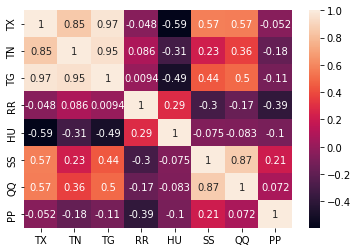

In [69]:
# Generate correlation matrix
corr = tours.corr(method='pearson')
# Draw the heatmap 
sns.heatmap(corr, 
              annot = True );   # Include values within squares

The obvious correlated parameters are the temperatures. The minimum and maximum temperatures are strongly correlated to the average temperature with a correlation factor greater than 0.95 and between each other (0.85).   
The sunshine hours and the total radiation also exhibit a strong correlation.   
We notice some weaker correlation, such as between the maximum temperature and the sunshine hours and the total radiation. And, parameters are negatively correlated, like the maximum temperature and the humidity. 


### "Noël au balcon, Pâques aux tisons ?"
In France, there is a phrase that reads "Noël au balcon, Pâques aux tisons". It basically means that if Christmas day is warm then next Easter will be a cold day. We can use our data to check this popular saying.
The first challenge is to get the date of Easter since it is not a fixed day. Fortunately, there is a Python function in _dateutil_ that does it. 

In [70]:
#Set the range of years to consider.
r=range(1961,2021)
#Initialize a dataframe with the years as indexes.
dfcor=pd.DataFrame(index=r)
#Fill in the dataframe with the mean temperatures of Christmas and the following Easter.
for d in r:
    dfcor.loc[d,'christmas']=tours.set_index('DATE').loc[str(d)+'-12-25','TG']
    dfcor.loc[d,'easter']=tours.set_index('DATE').loc[str(easter(d+1)),'TG']
print(dfcor.head())

      christmas  easter
1961       -1.8    12.4
1962       -8.0     8.4
1963       -0.7     4.8
1964        0.9     9.4
1965        7.8    11.4


To check the potential correlation between Christmas and Easter mean temperatures, we make a scatterplot and calculate the correlation coefficient with Pearson method.

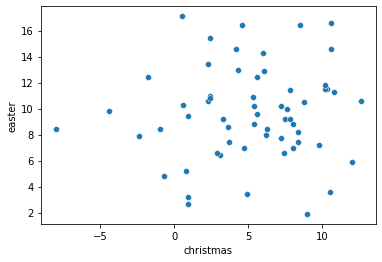

           christmas    easter
christmas   1.000000  0.083494
easter      0.083494  1.000000


In [71]:
sns.scatterplot(x='christmas', y='easter', data=dfcor)
plt.show()
print(dfcor.corr(method='pearson'))

The plot and the coefficient do not indicate any correlation. However, we can investigate in greater details. The saying states that warm Christmas leads to cold Easter, which not necessarily implies a correlation of the temperatures. Let us isolate warm Christmas year (with average temperature greater than 7°C) and compare the average Easter temperatures with other years. 

In [72]:
dfcor['warmXmas']= dfcor['christmas']>7
# print(dfcor.head())

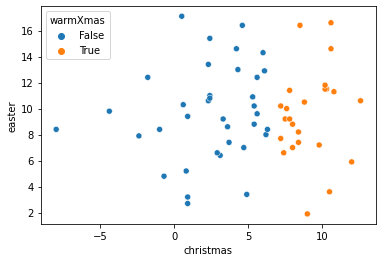

In [73]:
sns.scatterplot(x='christmas', y='easter', data=dfcor, hue='warmXmas')
plt.show()

In [74]:
dfcor.groupby('warmXmas')['easter'].mean()

warmXmas
False    9.691667
True     9.545833
Name: easter, dtype: float64

The difference of the mean Easter temperature is very small and we cannot qualify it as significant. To go further, we perform a bootstrap analysis. We start from the null hypothesis that both datasets, warm or cold christmas, are identical and thus by mixing and reassign them, we should be able to reproduce the same observation, here the difference of temperatures.   
This process is implemented at multiple times and at the end, we calculate the probability to get for our test statistic (difference of temperatures), a value at least as extreme as what was observed.


In [75]:
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""
    # Concatenate the data sets: data
    data =np.concatenate((data1, data2))
    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)
    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]
    return perm_sample_1, perm_sample_2
def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""
    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)
    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1,data_2)
        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1,perm_sample_2)
    return perm_replicates
def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""
    # The difference of means of data_1, data_2: diff
    diff = np.mean(data_1)-np.mean(data_2)
    return diff
# Compute difference of mean impact force from experiment: 
empirical_diff_means = diff_of_means(dfcor[dfcor['warmXmas']==True]['easter'],dfcor[dfcor['warmXmas']==False]['easter'])
# Draw 10,000 permutation replicates: perm_replicates
perm_replicates = draw_perm_reps(dfcor[dfcor['warmXmas']==True]['easter'],dfcor[dfcor['warmXmas']==False]['easter'], diff_of_means, size=10000)
# Compute p-value: p
p = np.sum(perm_replicates >= empirical_diff_means) / len(perm_replicates)
# Print the result
print('p-value =', p)

p-value = 0.5732


The p-value is very large, much larger than the usual 0.05 threshold of non-significancy. That strongly suggests that our null hypothesis is true and thus that there is no significant difference of average temperature of Easter following cold and warm Christmas.  We therefore cannot validate the popular saying.

## Machine Learning

Can we use monthly summary statistics to determine the season a given month belongs to?   
We will first apply the supervised KNN classification method.


### Classification

**Data preparation**  
Some preparation of the data is required, starting with the mapping of the month and season to have a reference. Then, we drop two columns, 'summer' because it would distort our Machine Learning and 'SS_sum' because too many data are missing. And, to improve the efficiency, the 'season' column type is set to *category*.


In [76]:
toursmth=monthstat(tours,1980)
#We won't need summer.
toursmth.drop(['summer','SS_sum'],1,inplace=True)
toursmth.dropna(inplace=True)
toursmth['season']=(toursmth.index.month%12+3)//3
seasons = {1: 'Winter',2: 'Spring',3: 'Summer',4: 'Autumn'}
toursmth['season'] = toursmth['season'].map(seasons)
toursmth['season']=toursmth['season'].astype('category')
#Reset index
toursmth.reset_index(inplace=True)
display(toursmth.head(3))

DATE    TX_mean  Warm days   TN_mean   TG_mean  RR_sum    HU_mean  \
0 1980-01-31   4.696774        0.0  0.096774  2.396774    60.3  82.000000   
1 1980-02-29  10.279310        0.0  4.224138  7.255172    67.1  88.344828   
2 1980-03-31   9.987097        0.0  3.561290  6.774194   122.2  84.096774   

   QQ_sum      PP_mean  season  
0   128.3  1015.922581  Winter  
1   183.0  1019.879310  Winter  
2   272.5  1010.680645  Spring

A *pairplot* is plotted, showing the correlation of the different parameters and their individual distribution. On this graphs, the data is coloured depending on the season. 

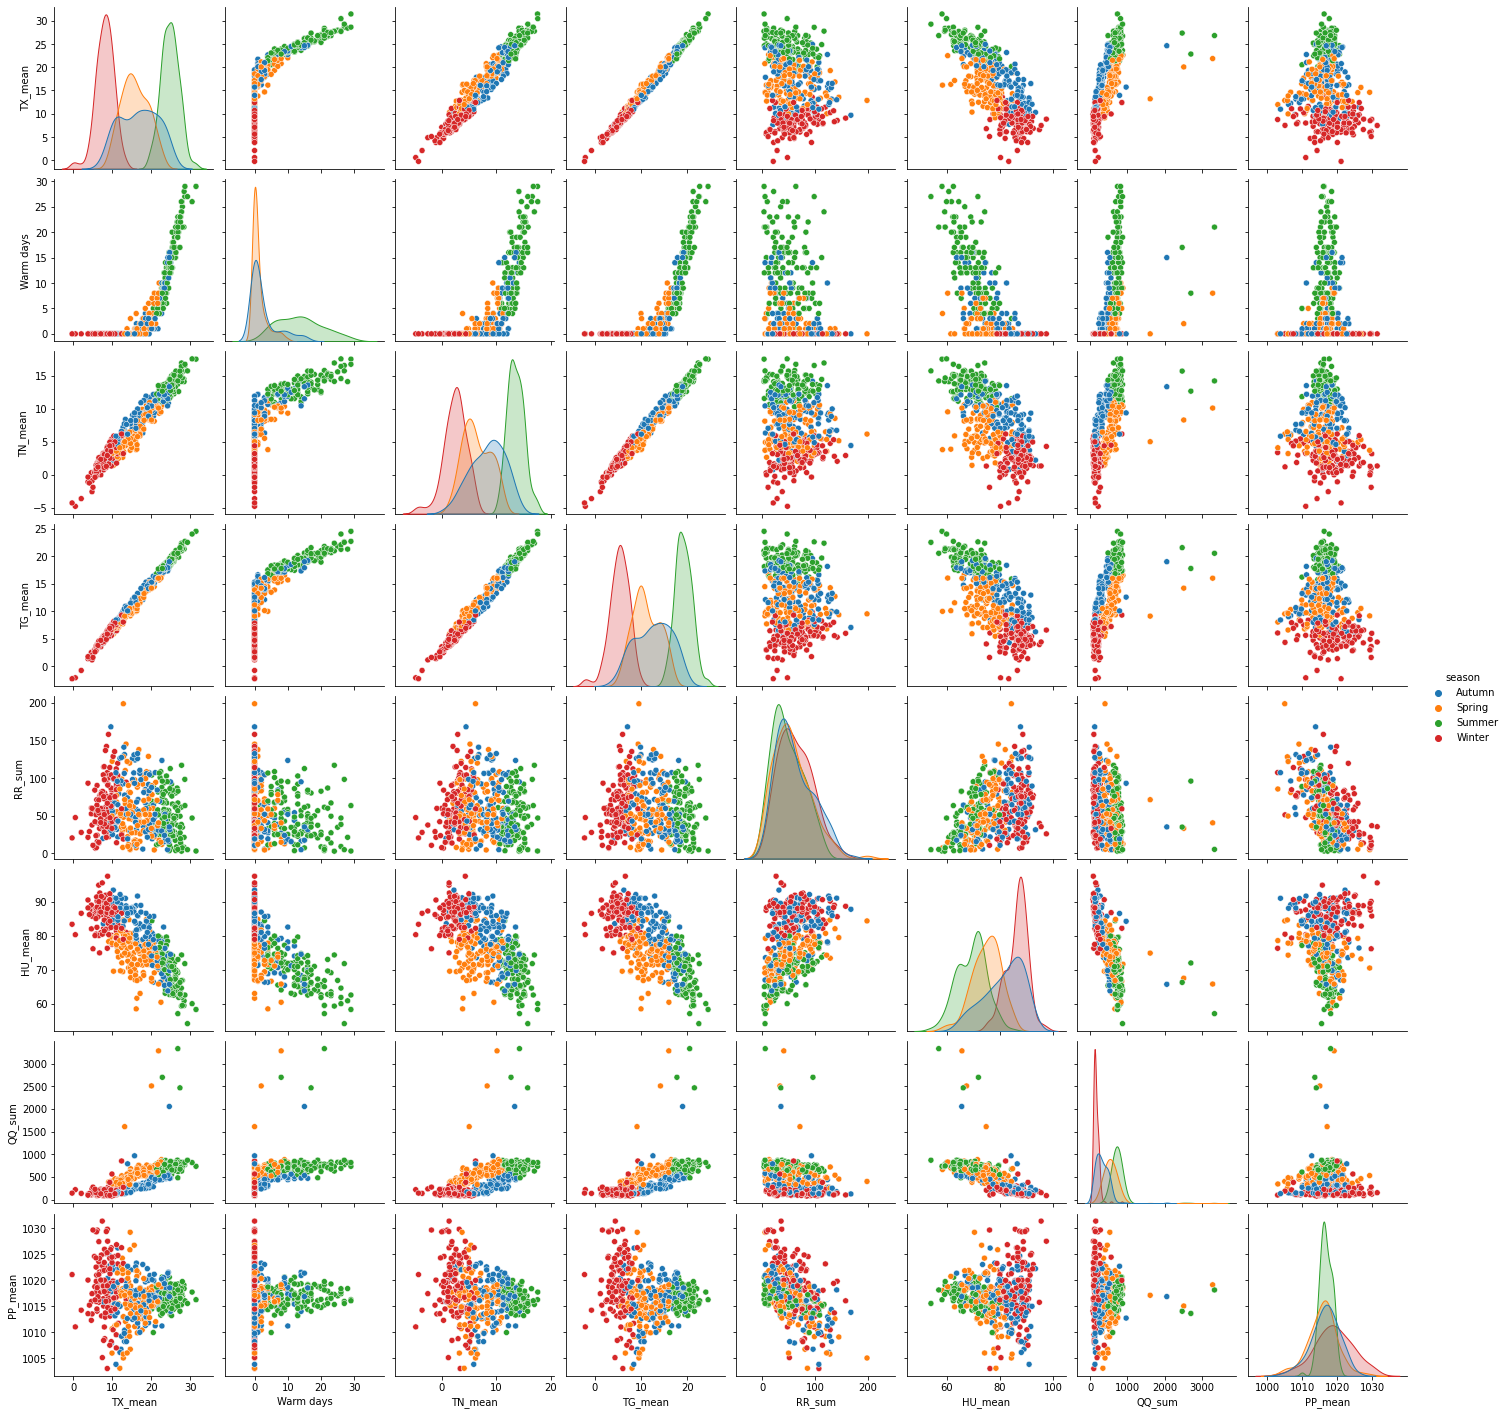

In [77]:
sns.pairplot(toursmth, hue='season')
plt.show()

It is not manifest for every parameter but we can in some cases identify a different behaviour according to the season the month belongs to. This sole differentiation might not be sufficient to predict the season but we are optimistic that the combination of all parameters would give good results.



**Machine learning parametrisation**   
*Features and target*  
We define the 'season' as the target and all the remaining columns but 'DATE' as the targets. 
The dataset is splitted between the training and testing sets.


In [78]:
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import train_test_split
# Create feature and target arrays
X = toursmth.drop(['season','DATE'],axis=1)
y = toursmth['season']
# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)

**Wise choice of the number of neighbours**   
The number of neighbours is a crucial paramater to determine. For this, we test various values and plot the train and test accuracy. 


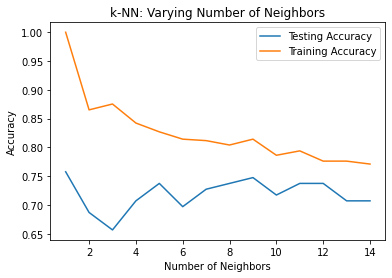

In [79]:
# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 15)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))
# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(k)
    # Fit the classifier to the training data
    knn.fit(X_train, y_train)    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)
    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)
# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

The best choice of the number of neighbors appears to be 5. However, we compare the testing score resulting of a K-NN classification with 5 and 7 neighbors.

In [80]:
# Create a k-NN classifier with 5 neighbors: knn
knn5 = KNeighborsClassifier(5)
# Fit the classifier to the training data
knn5.fit(X_train, y_train)
# Print the accuracy
print('5 neighbors k-NN classification score:')
print(knn5.score(X_test, y_test))
# Create a k-NN classifier with 7 neighbors: knn
knn7 = KNeighborsClassifier(7)
# Fit the classifier to the training data
knn7.fit(X_train, y_train)
# Print the accuracy
print('7 neighbors k-NN classification score:')
print(knn7.score(X_test, y_test))

5 neighbors k-NN classification score:
0.7373737373737373
7 neighbors k-NN classification score:
0.7272727272727273


The score with 7 neighbors, although pretty close, is lower than with 5 neighbors. We will stick with this value.    
We now have made an educated choice of the number of neighbors, however, there is still a bias due to the train/test splitting. 

**Unbiased train-test splitting**   
To address this bias, a cross-validation is used. Ten different splitting are performed and the average score is calculated. 


In [81]:
# Import the necessary modules
from sklearn.model_selection import cross_val_score
# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(knn5, X, y, cv=10)
# Print the 5-fold cross-validation scores
print(cv_scores)
print("Average 10-Fold CV Score with 5 neighbors: {}".format(np.mean(cv_scores)))

[0.78846154 0.80769231 0.63461538 0.75       0.72916667 0.77083333
 0.79166667 0.77083333 0.8125     0.64583333]
Average 10-Fold CV Score with 5 neighbors: 0.7501602564102564


**Possible improvement with scaling?**    
We considered many features whose variance can be different from one to another, so rescaling the values of the features before fitting a model might improve our accuracy. 

In [82]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
# Setup the pipeline steps: steps
steps = [('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier())]
# Create the pipeline: pipeline
pipeline = Pipeline(steps)
pipeline.fit(X_train, y_train)
# Print the accuracy
print(pipeline.score(X_test, y_test))
cv_scores = cross_val_score(pipeline, X, y, cv=10)
# Print the 5-fold cross-validation scores
print(cv_scores)
print("Average 10-Fold CV Score with 5 neighbors: {}".format(np.mean(cv_scores)))
y_pred=pipeline.predict(X_test)

0.7777777777777778
[0.80769231 0.80769231 0.78846154 0.89583333 0.79166667 0.91666667
 0.91666667 0.85416667 0.85416667 0.70833333]
Average 10-Fold CV Score with 5 neighbors: 0.8341346153846153


The average accuracy calculated from the cross-validation is significantly improved, by 10%.

**Alternative method?**   
Could we further improve our method by using Logistic Regression instead of k-NN?

In [83]:
from sklearn.linear_model import LogisticRegression
# Instantiate LogisticRegression
logreg = LogisticRegression(
    solver='liblinear',
    random_state=42
)

# Train the model
logreg.fit(X_train, y_train)

print(logreg.score(X_test, y_test))
cv_scores = cross_val_score(logreg, X, y, cv=10)
# Print the 5-fold cross-validation scores
print(cv_scores)
print("Average 10-Fold CV Score with 5 neighbors: {}".format(np.mean(cv_scores)))


0.8383838383838383
[0.86538462 0.84615385 0.84615385 0.91666667 0.8125     0.91666667
 0.83333333 0.9375     0.875      0.75      ]
Average 10-Fold CV Score with 5 neighbors: 0.8599358974358975


**Identify the wrongly assigned months?**   
We managed to reach up to 85% accuracy. One could wonder if some months are more difficult to categorize than others. We create a dataframe with both the prediction and the genuine season, as well as the month. Then, the number of failed predictions per month is plotted.

In [84]:
dfcheck=toursmth.loc[y_test.index,['DATE','season']]
dfcheck['seasonpred']=y_pred
dfcheck['Fail']=np.where(dfcheck["season"] != dfcheck["seasonpred"], True, False)
display(dfcheck.head(3))


DATE  season seasonpred   Fail
96  1988-01-31  Winter     Winter  False
356 2009-09-30  Autumn     Autumn  False
409 2014-02-28  Winter     Spring   True

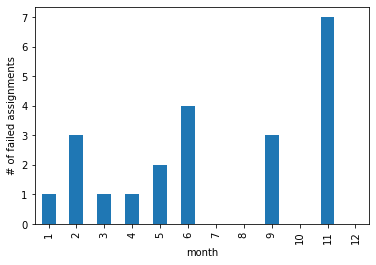

In [85]:
dfcheck['month']=dfcheck.DATE.dt.month
dfmthcheck=dfcheck.groupby('month')['Fail'].sum()
dfmthcheck.plot(kind='bar')
plt.ylabel("# of failed assignments")
plt.show()

On the considered sample, the season of November is badly predicted while the accuracy of the prediction for July, August and December is maximum.
However, one should consider those remarks with caution since there is not enough data to draw definitive conclusions on the efficiency of KNN with respect to the month. 

### Unsupervised clustering.
By implementing an unsupervised clustering, we could test the relevance of the traditional splitting of the months into four seasons in Tours. 
With this method, the algorithm cluster the observations that share similar features. 


We will employ the Kmeans method for which we need to specify the number of clusters. In order to determine the best value, the inertia of a set of values is plotted. Then, one has to seek for an elbow, *i.e.,* the point where the inertia starts to decrease more slowly.

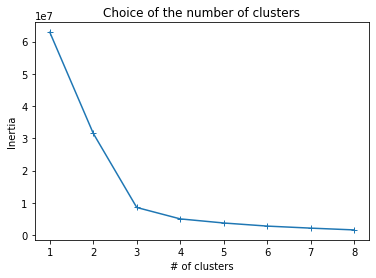

In [86]:
# Import KMeans
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
ks = range(1, 9)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model=KMeans(n_clusters=k)
    # Fit model to samples
    model.fit(X)
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
plt.plot(ks, inertias,marker='+')    
plt.ylabel('Inertia')
plt.xlabel('# of clusters')
plt.title('Choice of the number of clusters')
plt.show()

Here, the elbow method would point towards a choice of 3 or 4 clusters. We will continue with 4 clusters to fit with the usual classification.

We perform a KMeans clustering and compare the label assigned with the true season.

In [87]:
# Create a KMeans model with 4 clusters:
model = KMeans(n_clusters=4)
# Use fit_predict to fit model and obtain cluster labels: 
labels = model.fit_predict(X)
# Create a DataFrame with labels and season as columns: 
dfml = pd.DataFrame({'labels': labels, 'season': y})
# Create crosstab: 
ctml = pd.crosstab(dfml['labels'], dfml['season'])
display(ctml)


season  Autumn  Spring  Summer  Winter
labels                                
0           67       2       0     120
1            2      45     114       1
2            1       2       3       0
3           53      74       6       2

It returns a highly unbalanced splitting. A cluster includes most of the summer months and a significant share of spring months. Likewise another group includes most of the winter months and part of the autumn months. The remaining spring and autumn months are in a third cluster. Finally, the last cluster, very small, includes a handful of months of each season but winter, probably months with abnormal, rare features. 



We count the number of months included in each cluster.

In [88]:
display(dfml.groupby('labels').count())

season
labels        
0          189
1          162
2            6
3          135

Our feeling was correct, a cluster (with months from all seasons) is far smaller than the others. The largest is the winter cluster, including mainly winter and some autumn months, followed by the summer cluster and a middle-season cluster.  
To get more insight, we look more precisely at how months were clustered.

In [89]:
dfml2 =  pd.DataFrame({'labels': labels, 'month': toursmth.DATE.dt.month})
ctml2 = pd.crosstab(dfml2['labels'], dfml2['month'])
display(ctml2)

month   1   2   3   4   5   6   7   8   9   10  11  12
labels                                                
0       40  40   2   0   0   0   0   0   0  27  40  40
1        0   1   1  14  30  38  40  36   0   1   1   0
2        0   0   0   1   1   1   1   1   1   0   0   0
3        1   0  38  26  10   2   0   4  40  13   0   1

By the look of the table above, we get a better understanding of the different groups.
The largest group contains almost all November, December, January and February and most probably the coldest Octobers. The second one contains almost all June, July and August and seemingly summery May and fewer April. The remaining part of April, May and October together with September constitute the last group, we called mid-season.  

Therefore, the weather in Tours is more consistent with a three season model although a fourth cluster was necessary to gather the months with abnormal weather. 